## 어떤 예측 모형이 차량 수요 예측에 가장 적합할까?

### 라이브러리 호출

In [139]:
import os
import requests
from io import BytesIO
from itertools import product
from datetime import datetime

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# 분석
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pmdarima as pm  

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller # 정상성 검정
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings( 'ignore' )

print(pd.__version__)
print(sm.__version__)
print(pm.__version__)

1.2.0
0.12.1
1.8.3


### 데이터 로드 및 데이터 분리

In [140]:
# 파일 불러오기
file_path_raws = os.getenv('HOME') + '/raws.csv'
df_raws = pd.read_csv(file_path_raws)

# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday = pd.get_dummies(df_raws['weekday'], prefix='weekday', drop_first=False) # 원핫인코딩

_x_data = pd.concat([_x_data, _x_weekday], axis=1)

_x_data.set_index("target_dates", drop=True, inplace=True)
_x_data = _x_data.sort_values('target_dates')

# 예측 대상 데이터 설정
target = df_raws[['op_rate_0d_all_cars', 'target_dates' ]]

target.set_index("target_dates", drop=True, inplace=True)
target = target.sort_values('target_dates')

In [143]:
# Train/Test 데이터셋 나누기
_x_data_train = _x_data[_x_data.index<'2021-04-01']
_x_data_test = _x_data[_x_data.index>='2021-04-01']
target_train = target[target.index<'2021-04-01']
target_test = target[target.index>='2021-04-01']

x_train = _x_data_train
x_test = _x_data_test
y_train = target_train
y_test = target_test

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(571, 17) (52, 17) (571, 1) (52, 1)


### Grid search를 이용한 최상의 파라미터 조합 찾기

In [144]:
# 모수
p = range(0, 2) # AR(p) 차수 후보값 리스트
q = range(0, 2) # MA(q) 차수 후보값 리스트
d = range(0, 2) # 차분 차수 후보값 리스트
P = range(0, 2) # 계절성 AR(P) 차수 후보값 리스트
Q = range(0, 2) # 계절성 MA(Q) 차수 후보값 리스트
D = range(0, 2) # 계절성 차분 차수 후보값 리스트

# 초기화
best_AIC = float("inf")
best_model = sm.tsa.SARIMAX(endog=y_train, exog=x_train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 7))
iter_cnt = 0

In [145]:
# 모든 파라미터 조합에 대해 반복
total_combinations = len(p) * len(q) * len(d) * len(P) * len(Q) * len(D)

for (p_val, d_val, q_val, P_val, D_val, Q_val) in product(p, d, q, P, D, Q):
    iter_cnt += 1
    print(f"Iter {iter_cnt}/{total_combinations}: SARIMAX({p_val}, {d_val}, {q_val})x({P_val}, {D_val}, {Q_val})(7), ", end="")
    
    try:
        # 모델 생성 및 훈련
        model = sm.tsa.SARIMAX(endog=y_train, exog=x_train,
                               order=(p_val, d_val, q_val),
                               seasonal_order=(P_val, D_val, Q_val, 7))
        results = model.fit(disp=-1)

        # 현재 모델의 AIC 계산
        current_AIC = results.aic

        # 현재 AIC를 최소 AIC와 비교하여 업데이트
        if current_AIC < best_AIC:
            best_AIC = current_AIC
            best_model = results

        print(f"AIC = {current_AIC}")
    except:
        continue

print("그리드 탐색 완료.")
print(f"최적 SARIMA 모델 - AIC: {best_AIC}")
print(f"최적 SARIMA 모델 파라미터: {best_model.order}, {best_model.seasonal_order}")

Iter 1/64: SARIMAX(0, 0, 0)x(0, 0, 0)(7), AIC = 867.3483846700258
Iter 2/64: SARIMAX(0, 0, 0)x(0, 0, 1)(7), AIC = -2232.0394978926456
Iter 3/64: SARIMAX(0, 0, 0)x(0, 1, 0)(7), AIC = 1000.9463850813165
Iter 4/64: SARIMAX(0, 0, 0)x(0, 1, 1)(7), AIC = -2156.50227111441
Iter 5/64: SARIMAX(0, 0, 0)x(1, 0, 0)(7), AIC = -2244.151968996891
Iter 6/64: SARIMAX(0, 0, 0)x(1, 0, 1)(7), AIC = -2245.725946960656
Iter 7/64: SARIMAX(0, 0, 0)x(1, 1, 0)(7), AIC = -2097.2816526313522
Iter 8/64: SARIMAX(0, 0, 0)x(1, 1, 1)(7), AIC = -2141.838830446514
Iter 9/64: SARIMAX(0, 0, 1)x(0, 0, 0)(7), AIC = -2326.25584582184
Iter 10/64: SARIMAX(0, 0, 1)x(0, 0, 1)(7), AIC = -2348.6084755709994
Iter 11/64: SARIMAX(0, 0, 1)x(0, 1, 0)(7), AIC = -2097.1096732343863
Iter 12/64: SARIMAX(0, 0, 1)x(0, 1, 1)(7), AIC = -2237.58497479407
Iter 13/64: SARIMAX(0, 0, 1)x(1, 0, 0)(7), AIC = -2352.47294264588
Iter 14/64: SARIMAX(0, 0, 1)x(1, 0, 1)(7), AIC = -2354.9173561396033
Iter 15/64: SARIMAX(0, 0, 1)x(1, 1, 0)(7), AIC = -2183.92

AttributeError: 'SARIMAXResults' object has no attribute 'order'

SARIMA 모델의 파라미터는 order와 seasonal_order 속성을 통해 접근할 수 있다. 그러나 에러 메시지에서 보듯이 best_model은 SARIMAXResults 객체이므로 order와 seasonal_order 속성이 없다. 정확한 파라미터 값을 출력하기 위해서는 다음과 같이 수정해야 한다.

위 코드에서 best_model.model.order와 best_model.model.seasonal_order를 통해 정확한 파라미터 값을 출력할 수 있다.

In [146]:
print("그리드 탐색 완료.")
print(f"최적 SARIMA 모델 - AIC: {best_AIC}")
print("최적 SARIMA 모델 파라미터:")
print(f"order: {best_model.model.order}")
print(f"seasonal_order: {best_model.model.seasonal_order}")

그리드 탐색 완료.
최적 SARIMA 모델 - AIC: -2366.2483215650855
최적 SARIMA 모델 파라미터:
order: (1, 0, 1)
seasonal_order: (1, 0, 1, 7)


그리드 탐색을 통해 가장 낮은 AIC를 가지는 파라미터 조합을 얻어냈다.

### 모형 구조 확인

In [147]:
# 모형 구조 확인
model.summary()

AttributeError: 'SARIMAX' object has no attribute 'summary'

statsmodels의 SARIMAX 모델에는 summary() 메서드가 존재하지 않는다. summary() 메서드는 보통 statsmodels의 회귀 모델에서 사용되며, SARIMAX 모델에는 없다. SARIMAX 모델의 정보를 확인하기 위해서는 다른 방법을 사용해야 한다.

SARIMAX 모델의 속성과 메서드 중에서 아래와 같은 것들을 사용하여 모델의 정보를 확인할 수 있다.

- results.summary(): SARIMAX 모델의 적합 결과 요약 정보를 출력.
- results.plot_diagnostics(): 모델의 진단 그래프를 그림. 잔차, 자기상관 함수, 정규성 등을 시각화하여 확인할 수 있음.
- results.get_prediction(): 예측 결과를 가져옴.
- results.forecast(steps=n): n 스텝의 미래 예측값을 계산함.
- results.get_forecast(steps=n): n 스텝의 미래 예측값과 신뢰구간을 계산함.

In [148]:
# 모델 적합성 
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:               op_rate_0d_all_cars   No. Observations:                  571
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                1081.134
Date:                           Fri, 01 Sep 2023   AIC                          -2118.268
Time:                                   06:36:46   BIC                          -2022.936
Sample:                               09-08-2019   HQIC                         -2081.052
                                    - 03-31-2021                                         
Covariance Type:                             opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
click_d_1          6.405e-06   7.28e-07      8.793      0.000    4.98e-06    7.83e-06
click_d_2         -2.0

- Ljung-Box(L1)의 값은 0.49, Prob(Q) 값은 0.48로 잔차가 상관되어 있지 않을 가능성이 높다.
- Jarque-Bera 값은 680.17, Prob(JB) 값은 0.00으로 잔차가 정규 분포를 따르지 않을 가능성이 높다.
- Heteroskedasticity 값은 1.48, Prob(H) 값은 0.01로 잔차의 분산이 일정하지 않을 가능성이 높다.

=> 현재 모형이 적합하지 않을 수 있다.

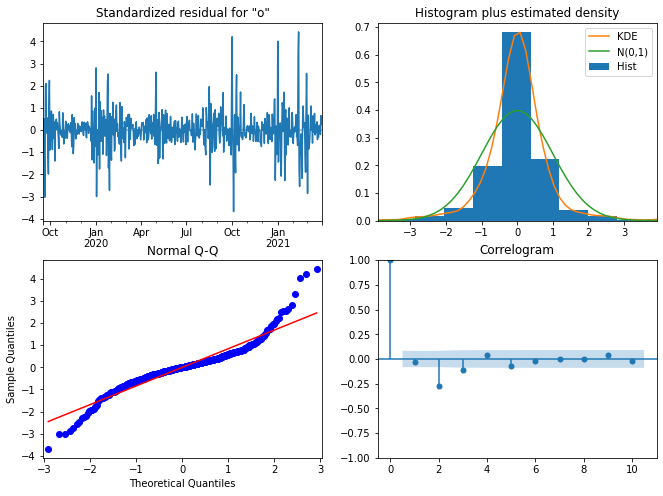

In [149]:
# 잔차 확인
results.plot_diagnostics(figsize=(11, 8))
plt.show()

### 차량 수요 예측

In [150]:
# 예측값 얻기
forecast = best_model.get_forecast(steps=len(y_test), exog=_x_data_test.values)

# 예측값의 신뢰 구간 얻기
confidence_intervals = forecast.conf_int().values

# MSE 계산(실제값 - 예측값)
actual_values = target_test['op_rate_0d_all_cars']
predicted_mean = forecast.predicted_mean
mse = mean_squared_error(actual_values, predicted_mean)

# RMSE 계산
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

RMSE: 0.022641979198986743


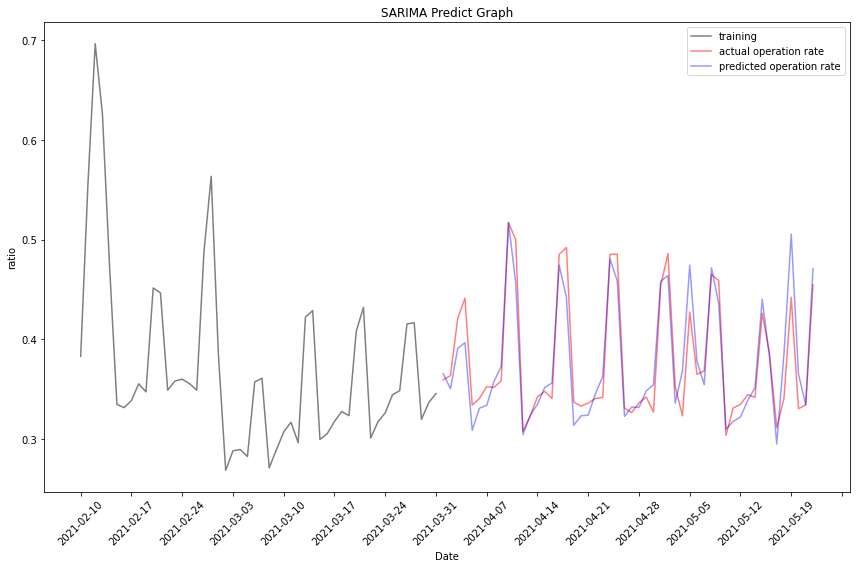

In [151]:
# 예측 수행(예측을 시작하고 끝내는 데이터 인덱스 지정)
pred_test = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=_x_data_test)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) # x축 눈금 위치 설정(7일 간격)
ax.xaxis.set_major_locator(loc) # 눈금 위치 'loc'을 x축에 적용

plt.plot(y_train[-50:], alpha=0.5, color='black', label='training') # 학습 데이터의 마지막 50개 데이터
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate') # 테스트 데이터
plt.plot(y_test.index, pred_test, alpha=0.4, color='blue', label='predicted operation rate') # 예측된 값
plt.legend()

plt.xlabel('Date')
plt.ylabel('ratio')
plt.title('SARIMA Predict Graph')
plt.tight_layout()
plt.show()

RMSE 값이 낮게 나왔고 시각화 결과 어느 정도 예측을 잘 하긴 했다.

### 다른 모형 사용: LGBM

In [153]:
# LightGBM 모델링
from lightgbm import LGBMRegressor

# 모델 생성
lgbm_model = LGBMRegressor()

# 모델 훈련 및 예측
lgbm_model.fit(x_train, y_train['op_rate_0d_all_cars'])
lgbm_pred = lgbm_model.predict(x_test)

# RMSE 계산
lgbm_rmse = np.sqrt(mean_squared_error(y_test['op_rate_0d_all_cars'], lgbm_pred))

print(f"RMSE: {lgbm_rmse}")

RMSE: 0.023250716422417043


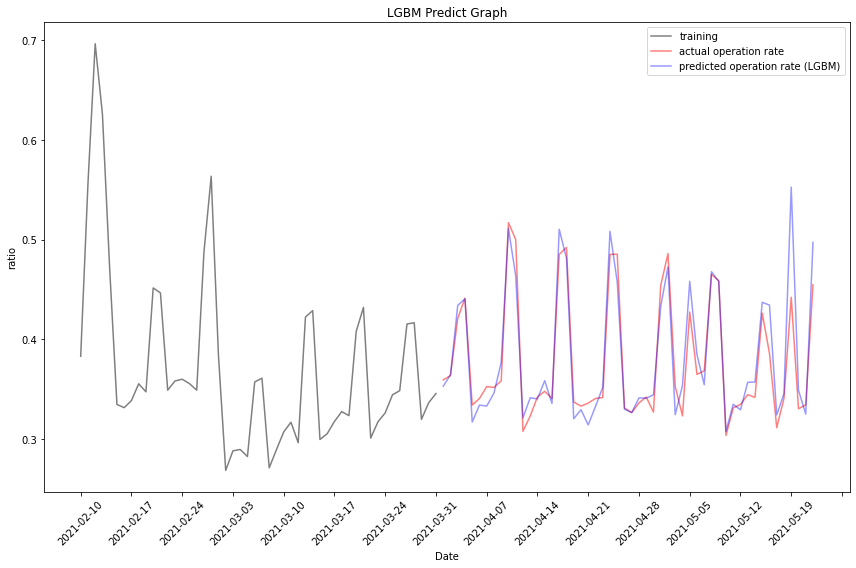

In [154]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0)
ax.xaxis.set_major_locator(loc)

plt.plot(y_train[-50:], alpha=0.5, color='black', label='training') # 학습 데이터의 마지막 50개 데이터
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate') # 테스트 데이터

# LGBM 모델의 예측 결과 시각화
plt.plot(y_test.index, lgbm_pred, alpha=0.4, color='blue', label='predicted operation rate (LGBM)')
plt.legend()

plt.xlabel('Date')
plt.ylabel('ratio')
plt.title('LGBM Predict Graph')
plt.tight_layout()
plt.show()

### 다른 모형 사용: XGB

In [155]:
# XGBoost 모델링
from xgboost import XGBRegressor

# 모델 생성
xgb_model = XGBRegressor()

# 모델 훈련 및 예측
xgb_model.fit(x_train, y_train['op_rate_0d_all_cars'])
xgb_pred = xgb_model.predict(x_test)

# RMSE 계산
xgb_rmse = np.sqrt(mean_squared_error(y_test['op_rate_0d_all_cars'], xgb_pred))

print(f"RMSE: {xgb_rmse}")

RMSE: 0.026263643162349717


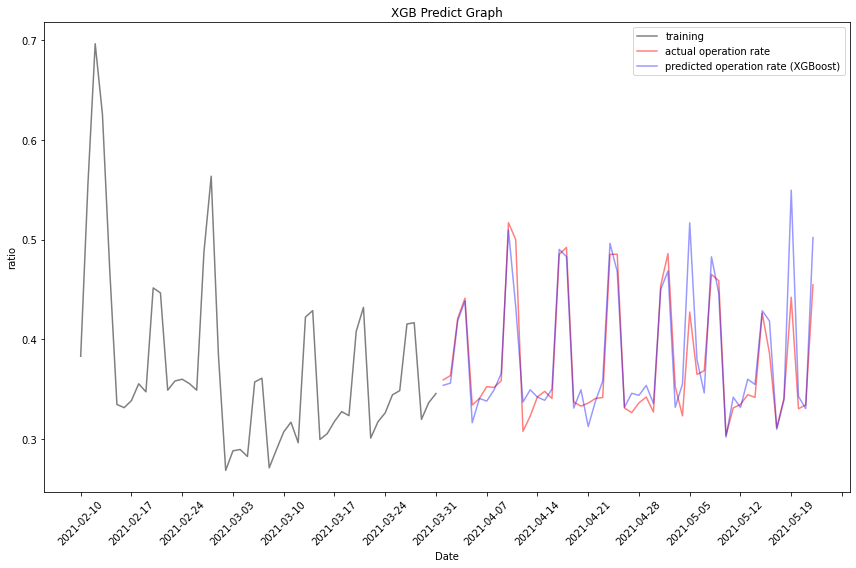

In [156]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0)
ax.xaxis.set_major_locator(loc)

plt.plot(y_train[-50:], alpha=0.5, color='black', label='training') # 학습 데이터의 마지막 50개 데이터
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate') # 테스트 데이터

# XGBoost 모델의 예측 결과 시각화
plt.plot(y_test.index, xgb_pred, alpha=0.4, color='blue', label='predicted operation rate (XGBoost)')
plt.legend()

plt.xlabel('Date')
plt.ylabel('ratio')
plt.title('XGB Predict Graph')
plt.tight_layout()
plt.show()

### 다른 모형 사용: Random Forest

In [157]:
# RandomForest 모델링
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
rf_model = RandomForestRegressor()

# 모델 훈련 및 예측
rf_model.fit(x_train, y_train['op_rate_0d_all_cars'])
rf_pred = rf_model.predict(x_test)

# RMSE 계산
rf_rmse = np.sqrt(mean_squared_error(y_test['op_rate_0d_all_cars'], rf_pred))

print(f"RMSE: {rf_rmse}")

RMSE: 0.02010084176908922


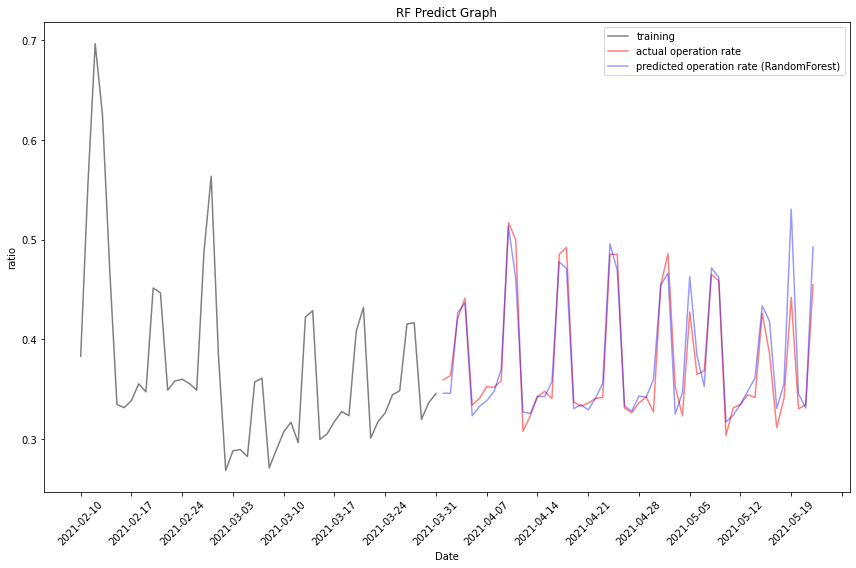

In [158]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0)
ax.xaxis.set_major_locator(loc)

plt.plot(y_train[-50:], alpha=0.5, color='black', label='training') # 학습 데이터의 마지막 50개 데이터
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate') # 테스트 데이터

# RandomForest 모델의 예측 결과 시각화
plt.plot(y_test.index, rf_pred, alpha=0.4, color='blue', label='predicted operation rate (RandomForest)')
plt.legend()

plt.xlabel('Date')
plt.ylabel('ratio')
plt.title('RF Predict Graph')
plt.tight_layout()
plt.show()

### 결과 비교

In [160]:
# 각 모델별 예측 결과와 실제값 간의 RMSE 계산
rmse_results = {
    'Model': ['SARIMAX', 'LGBM', 'XGB', 'RandomForest'],
    'RMSE': [rmse, lgbm_rmse, xgb_rmse, rf_rmse]
}

# 결과를 데이터프레임으로 생성
rmse_df = pd.DataFrame(rmse_results)
rmse_df.sort_values(by = 'RMSE')

,Model,RMSE
3,RandomForest,0.020101
0,SARIMAX,0.022642
1,LGBM,0.023251
2,XGB,0.026264


총 4가지 모델을 사용했고, 예측 결과, __RandomForest__ 모델이 RMSE가 약 0.02 정도로 가장 낮은 수치를 보였다.

## 회고

### 어려웠던 점 / 느낀점
> - 이번 프로젝트는 시계열 데이터를 SARIMAX 모델로 예측하는 것이었다. 우선 이 모델 자체를 다루는 것이 어려웠다. 관련된 수학적, 통계학적 이론을 이해하는 것부터가 난관이었다. 짧은 시간 내에 이 내용 완벽하게 이해하는 것은 힘든 일이다. 우선은 이 프로젝트를 제한된 시간 내에 해결해야 했으므로 검색의 도움을 많이 받아서 코드를 구현한 점이 조금 아쉬웠다.  앞으로 수학적, 통계학적 이론을 개인적으로 공부하고 스스로 해결하려고 노력하는 습관을 길러야겠다고 생각했다.  
> -  학습 노드에서 SARIMAX 모델을 다룰 때 보통 Grid search를 사용해 최적의 파라미터를 찾고 모델링을 한다고 했다. 하지만 학습 노트에서 Grid search를 제외하여 학습을 진행시켰는데, 프로젝트에서는 Grid search를 사용하는 것이 미션이었다. 그래서 개인적으로 Grid search에 대해 알아봐야 했다. 찾아봤을 때, 처음 시도하는 코드여서 에러가 많이 발생했다. 에러를 해결하려고 ChatGPT와 영상 등의 도움을 받았다.

### 학습한 내용
> - 시계열 데이터를 다루기 위해 여러 모델을 사용했다. ARIMA, SARIMA, SARIMAX 모형과 LGBM, XGB, RandomForest 모형을 사용했다. 처음 언급한 세 모델이 어떤 차이점이 있는지 학습했고, 각 모델에 필요한 파라미터에 대해 배웠다. 
> - 데이터를 모델에 학습시키고 예측한 값에 대한 summary()를 출력하여 해석하는 방법을 배웠다. 출력값에 여러가지 키워드가 있었고, 각 키워드가 의미하는 가설이 무엇인지 학습했다. 여기서 p-value 값이 중요한 것이라고 생각했다. 
> - 데이터를 모델이 학습시키고 예측한 값을 시각화하고 rmse 값을 구해 모델이 잘 학습된 것이 맞는지 판단하는 과정을 학습했다.

## 참고
- https://www.youtube.com/watch?v=TNmI9v49mlM
- https://www.youtube.com/watch?v=zTB7uWNvaN4&t=717s